In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import stats
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import test.utils as test

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)

UMI = UMI_c57 + UMI_cast

# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

adata = ad.AnnData(UMI_T)
adata.layers['spliced'] = UMI_c57_T
adata.layers['unspliced'] = UMI_cast_T

gtf = pd.read_csv("data/Mus_musculus.GRCm38.102.chr.gtf", sep='\t', skiprows=5, header=None)
gtf.columns = ['chr', 'database', 'type', 'start', 'end', '.', 'strand', '.', 'other']
gtf = gtf[gtf['type'] == "gene"]
gtf = gtf.reset_index()

dic_gene_names = {}
index = 0
for line in gtf['other'].tolist():
    line = line.split(';')
    dic_gene_names[line[0][9:-1]]= [gtf['chr'][index], line[2][12:-1]]
    index += 1
    
adata.var['gene_name'] = [dic_gene_names[x][1] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]
adata.var['chromosome'] = [dic_gene_names[x][0] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]


label = []
for chrom in adata.var['chromosome']:
    if chrom == "X":
        label.append('X')
    elif chrom == "Y":
        label.append('Y')
    else:
        label.append('autosome')
adata.var['autosomes'] = label

label = []
for chrom in adata.var['chromosome']:
    if chrom == "MT":
        label.append('MT')
    else:
        label.append('nuclear')
adata.var['nuclear'] = label

label = []
for genes in adata.var['gene_name']:
    if genes[:2]=='Rp':
        label.append('Ribosomal protein')
    else:
        label.append('other protein')
adata.var['Ribosomal_prot'] = label

test.remove_na(adata)
test.find_ratios_sum(adata)
test.find_ratios_std(adata)

sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['clusters'] = adata.obs['leiden'].copy()
               

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [4]:
adata.var

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2
ENSMUSG00000000001,Gnai3,3,autosome,nuclear,other protein,8956.0,10024.0,0.471865,0.528135,321.291178,360.708822,0.471101,0.528899,0.157535,0.157535
ENSMUSG00000000049,Apoh,11,autosome,nuclear,other protein,46.0,48.0,0.489362,0.510638,29.500000,34.500000,0.460938,0.539062,0.498447,0.498447
ENSMUSG00000000088,Cox5a,9,autosome,nuclear,other protein,7514.0,7028.0,0.516710,0.483290,350.605317,331.394683,0.514084,0.485916,0.151797,0.151797
ENSMUSG00000000120,Ngfr,11,autosome,nuclear,other protein,0.0,4.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000
ENSMUSG00000000184,Ccnd2,6,autosome,nuclear,other protein,36198.0,33010.0,0.523032,0.476968,357.947744,324.052256,0.524850,0.475150,0.144606,0.144606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100620,Gm28277,1,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000103811,Gm38004,9,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000112500,4933411E08Rik,10,autosome,nuclear,other protein,6.0,0.0,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000114922,Ppifos,14,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='ratio_allele_1', ylabel='Density'>

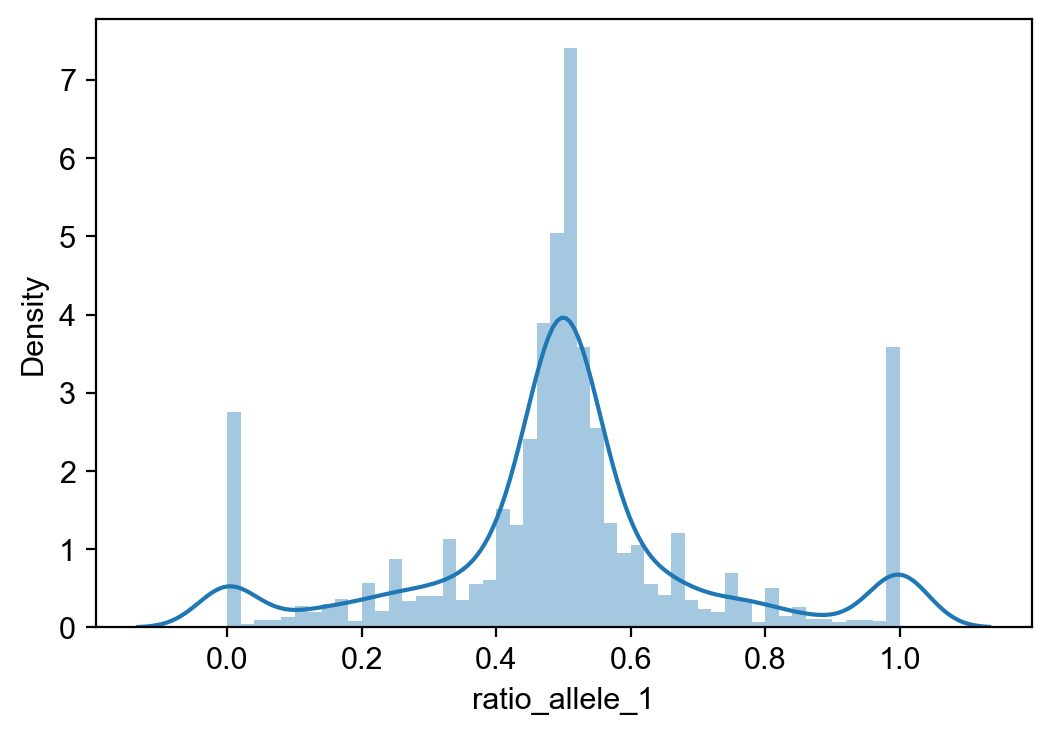

In [5]:
sns.distplot(adata.var.ratio_allele_1)

<AxesSubplot:xlabel='ratio_allele_2', ylabel='Density'>

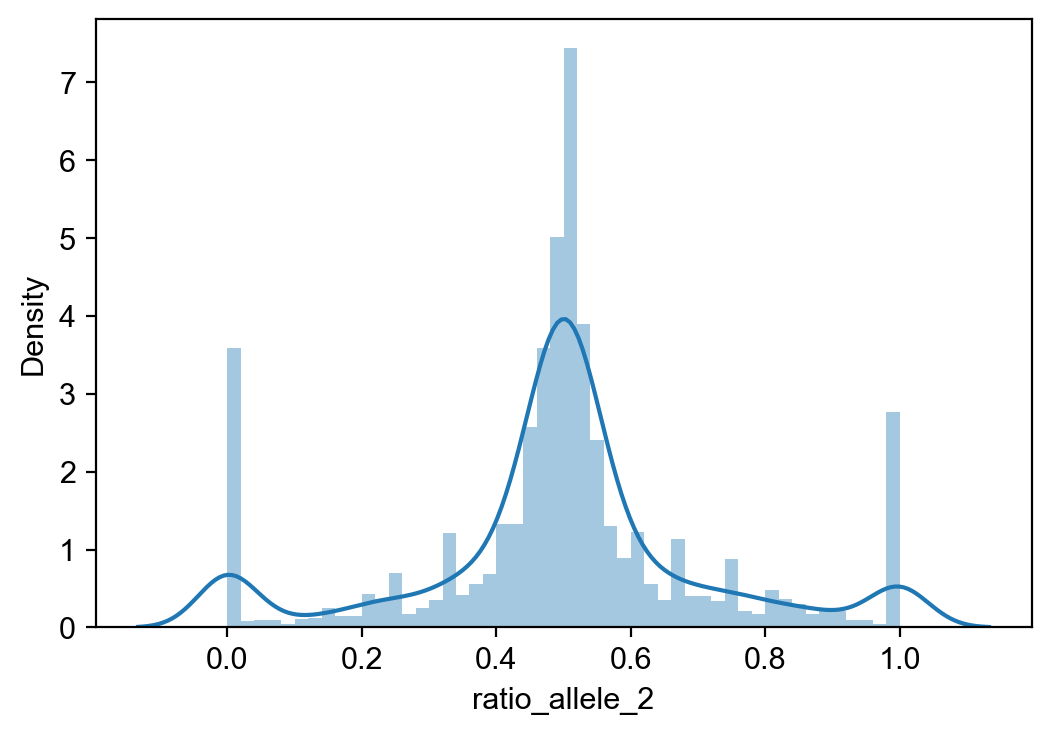

In [6]:
sns.distplot(adata.var.ratio_allele_2)

In [7]:
PoO_1 = adata.var[(adata.var.ratio_allele_1 == 0.0) | (adata.var.ratio_allele_1 == 1.0)].index
PoO_2 = adata.var[(adata.var.ratio_allele_2 == 0.0) | (adata.var.ratio_allele_2 == 1.0)].index
PoO = list(set(PoO_1.union(PoO_2)))
len(PoO)

358

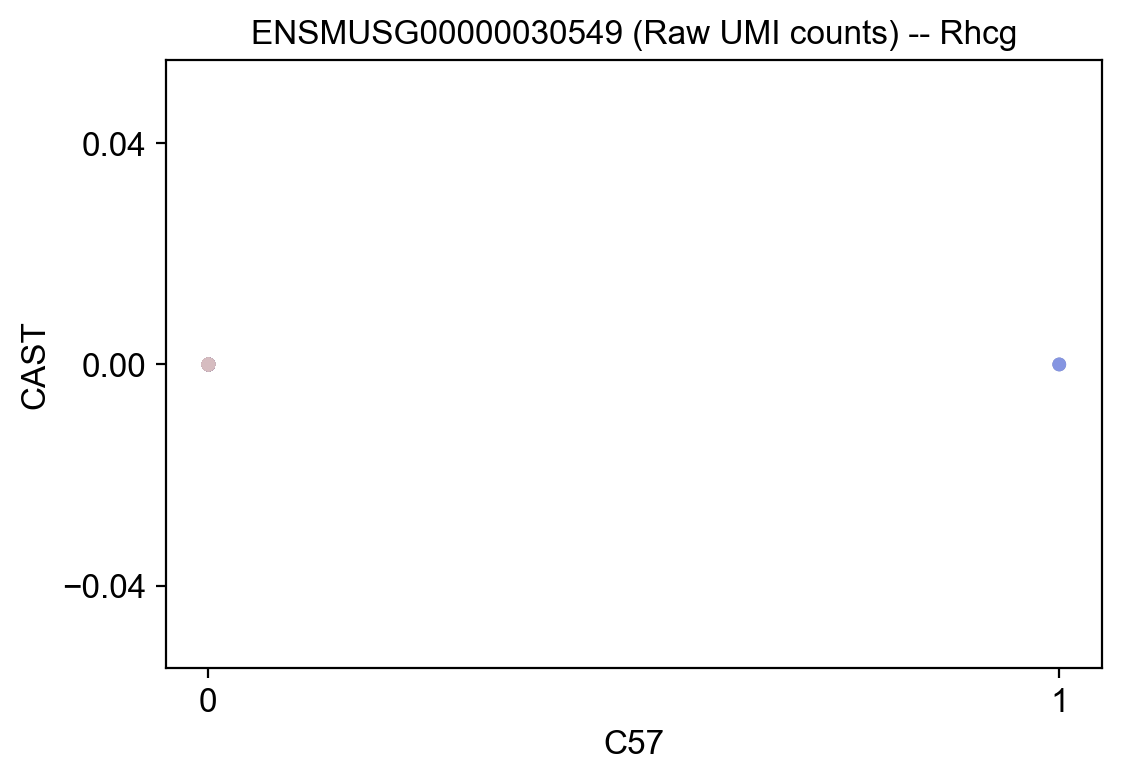

In [8]:
import random
x = PoO[random.randint(0,len(PoO) - 1)]

scv.pl.scatter(adata, x, color=['clusters'], xlabel='C57', ylabel='CAST', 
               title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])}")


In [9]:
label = []
for x in adata.var.index:
    if x in PoO:
        label.append(0)
    else:
        label.append(1)
adata.var['fit_class'] = label

In [10]:
adata.var

,gene_name,chromosome,autosomes,nuclear,Ribosomal_prot,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2,fit_class
ENSMUSG00000000001,Gnai3,3,autosome,nuclear,other protein,8956.0,10024.0,0.471865,0.528135,321.291178,360.708822,0.471101,0.528899,0.157535,0.157535,1
ENSMUSG00000000049,Apoh,11,autosome,nuclear,other protein,46.0,48.0,0.489362,0.510638,29.500000,34.500000,0.460938,0.539062,0.498447,0.498447,1
ENSMUSG00000000088,Cox5a,9,autosome,nuclear,other protein,7514.0,7028.0,0.516710,0.483290,350.605317,331.394683,0.514084,0.485916,0.151797,0.151797,1
ENSMUSG00000000120,Ngfr,11,autosome,nuclear,other protein,0.0,4.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0
ENSMUSG00000000184,Ccnd2,6,autosome,nuclear,other protein,36198.0,33010.0,0.523032,0.476968,357.947744,324.052256,0.524850,0.475150,0.144606,0.144606,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100620,Gm28277,1,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0
ENSMUSG00000103811,Gm38004,9,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0
ENSMUSG00000112500,4933411E08Rik,10,autosome,nuclear,other protein,6.0,0.0,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0
ENSMUSG00000114922,Ppifos,14,autosome,nuclear,other protein,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0


In [11]:
adata.layers['unspliced'].shape

(682, 3134)

In [12]:
allele_1 = pd.DataFrame(adata.layers['spliced'], columns=adata.var.index)
allele_2 = pd.DataFrame(adata.layers['unspliced'], columns=adata.var.index)

In [13]:
allele_1_T = allele_1.transpose(copy=True)
allele_2_T = allele_2.transpose(copy=True)

In [14]:
# differentiating allele 1 and allele 2 UMI counts
allele_T = allele_1_T - allele_2_T

In [15]:
allele_T['fit_class'] = adata.var['fit_class']

In [16]:
allele_T

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,fit_class
ENSMUSG00000000001,9.0,-8.0,-13.0,-4.0,5.0,-12.0,-11.0,-11.0,-2.0,-3.0,...,-6.0,-1.0,-2.0,6.0,-1.0,-2.0,2.0,2.0,4.0,1
ENSMUSG00000000049,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ENSMUSG00000000088,6.0,8.0,7.0,6.0,-6.0,20.0,16.0,-7.0,21.0,-13.0,...,0.0,-5.0,-2.0,0.0,0.0,0.0,-3.0,-1.0,1.0,1
ENSMUSG00000000120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000000184,-35.0,16.0,-40.0,13.0,63.0,-62.0,60.0,28.0,-26.0,-6.0,...,2.0,13.0,14.0,-6.0,8.0,6.0,8.0,-16.0,-14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000103811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000112500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000114922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
test_set_1=allele_T[allele_T['fit_class']==0].head(15).index
test_set_1

Index(['ENSMUSG00000000120', 'ENSMUSG00000004328', 'ENSMUSG00000007877',
       'ENSMUSG00000013418', 'ENSMUSG00000013611', 'ENSMUSG00000015950',
       'ENSMUSG00000016458', 'ENSMUSG00000019828', 'ENSMUSG00000019932',
       'ENSMUSG00000020299', 'ENSMUSG00000020672', 'ENSMUSG00000020872',
       'ENSMUSG00000023057', 'ENSMUSG00000024114', 'ENSMUSG00000024922'],
      dtype='object')

In [18]:
test_set_2=allele_T[allele_T['fit_class']==1].head(25).index
test_set_2

Index(['ENSMUSG00000000001', 'ENSMUSG00000000049', 'ENSMUSG00000000088',
       'ENSMUSG00000000184', 'ENSMUSG00000000295', 'ENSMUSG00000000303',
       'ENSMUSG00000000326', 'ENSMUSG00000000339', 'ENSMUSG00000000346',
       'ENSMUSG00000000378', 'ENSMUSG00000000489', 'ENSMUSG00000000563',
       'ENSMUSG00000000673', 'ENSMUSG00000000693', 'ENSMUSG00000000732',
       'ENSMUSG00000000740', 'ENSMUSG00000000743', 'ENSMUSG00000000753',
       'ENSMUSG00000000792', 'ENSMUSG00000000805', 'ENSMUSG00000000826',
       'ENSMUSG00000000827', 'ENSMUSG00000000902', 'ENSMUSG00000000903',
       'ENSMUSG00000000957'],
      dtype='object')

In [19]:
test_set=test_set_1.union(test_set_2)
test_set = list(set(test_set))
test_set_suffled = random.sample(test_set, len(test_set))

In [20]:
test_set_suffled

['ENSMUSG00000000827',
 'ENSMUSG00000000805',
 'ENSMUSG00000007877',
 'ENSMUSG00000000826',
 'ENSMUSG00000019932',
 'ENSMUSG00000000378',
 'ENSMUSG00000000903',
 'ENSMUSG00000020872',
 'ENSMUSG00000024114',
 'ENSMUSG00000000957',
 'ENSMUSG00000013611',
 'ENSMUSG00000000339',
 'ENSMUSG00000000088',
 'ENSMUSG00000000740',
 'ENSMUSG00000000732',
 'ENSMUSG00000000902',
 'ENSMUSG00000000120',
 'ENSMUSG00000000326',
 'ENSMUSG00000000563',
 'ENSMUSG00000000792',
 'ENSMUSG00000000743',
 'ENSMUSG00000004328',
 'ENSMUSG00000000184',
 'ENSMUSG00000024922',
 'ENSMUSG00000000049',
 'ENSMUSG00000016458',
 'ENSMUSG00000013418',
 'ENSMUSG00000000753',
 'ENSMUSG00000000673',
 'ENSMUSG00000023057',
 'ENSMUSG00000015950',
 'ENSMUSG00000000489',
 'ENSMUSG00000020672',
 'ENSMUSG00000000001',
 'ENSMUSG00000019828',
 'ENSMUSG00000020299',
 'ENSMUSG00000000303',
 'ENSMUSG00000000693',
 'ENSMUSG00000000346',
 'ENSMUSG00000000295']

In [21]:
test_set_csv = allele_T.loc[test_set_suffled]

In [22]:
test_set_csv.to_csv("data/classifier/test_set.csv", sep=";")

In [23]:
allele_T

,0,1,2,3,4,5,6,7,8,9,...,673,674,675,676,677,678,679,680,681,fit_class
ENSMUSG00000000001,9.0,-8.0,-13.0,-4.0,5.0,-12.0,-11.0,-11.0,-2.0,-3.0,...,-6.0,-1.0,-2.0,6.0,-1.0,-2.0,2.0,2.0,4.0,1
ENSMUSG00000000049,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ENSMUSG00000000088,6.0,8.0,7.0,6.0,-6.0,20.0,16.0,-7.0,21.0,-13.0,...,0.0,-5.0,-2.0,0.0,0.0,0.0,-3.0,-1.0,1.0,1
ENSMUSG00000000120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000000184,-35.0,16.0,-40.0,13.0,63.0,-62.0,60.0,28.0,-26.0,-6.0,...,2.0,13.0,14.0,-6.0,8.0,6.0,8.0,-16.0,-14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000103811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000112500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ENSMUSG00000114922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
train_set = [x for x in list(allele_T.index) if x not in test_set_suffled]
len(train_set)

3094

In [25]:
train_set_suffled = random.sample(train_set, len(train_set))
train_set_suffled

['ENSMUSG00000020712',
 'ENSMUSG00000075596',
 'ENSMUSG00000021967',
 'ENSMUSG00000026181',
 'ENSMUSG00000026188',
 'ENSMUSG00000022956',
 'ENSMUSG00000028779',
 'ENSMUSG00000087014',
 'ENSMUSG00000075573',
 'ENSMUSG00000075370',
 'ENSMUSG00000025337',
 'ENSMUSG00000026509',
 'ENSMUSG00000099478',
 'ENSMUSG00000020044',
 'ENSMUSG00000090121',
 'ENSMUSG00000027287',
 'ENSMUSG00000028792',
 'ENSMUSG00000003549',
 'ENSMUSG00000090500',
 'ENSMUSG00000025151',
 'ENSMUSG00000067274',
 'ENSMUSG00000045589',
 'ENSMUSG00000081236',
 'ENSMUSG00000062328',
 'ENSMUSG00000061718',
 'ENSMUSG00000030744',
 'ENSMUSG00000002458',
 'ENSMUSG00000081265',
 'ENSMUSG00000026032',
 'ENSMUSG00000030706',
 'ENSMUSG00000018395',
 'ENSMUSG00000019837',
 'ENSMUSG00000005054',
 'ENSMUSG00000028410',
 'ENSMUSG00000058655',
 'ENSMUSG00000020149',
 'ENSMUSG00000020986',
 'ENSMUSG00000022503',
 'ENSMUSG00000019467',
 'ENSMUSG00000112352',
 'ENSMUSG00000078772',
 'ENSMUSG00000021234',
 'ENSMUSG00000026395',
 'ENSMUSG00

In [26]:
train_set_csv = allele_T.loc[train_set_suffled]

In [27]:
train_set_csv.to_csv("data/classifier/train_set.csv", sep=";")